In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
from datetime import datetime, timedelta

import keras
import tensorflow

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Any results you write to the current directory are saved as output.
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
#load the data
data = pd.read_csv('energy_dataset.csv',
                   index_col=[0],
                   parse_dates=True)

dates = pd.date_range(start='2014-12-31T2300', end='2018-12-31T2200', freq='H')
data.index = pd.DatetimeIndex(dates).tz_localize('UTC').tz_convert('Europe/Madrid')
df = data[['total load actual', 'total load forecast']]

null_vals = df.isnull().sum()
print('Null values in the target column {}'.format(null_vals))
df.head()

Null values in the target column total load actual      36
total load forecast     0
dtype: int64


,total load actual,total load forecast
2015-01-01 00:00:00+01:00,25385.0,26118.0
2015-01-01 01:00:00+01:00,24382.0,24934.0
2015-01-01 02:00:00+01:00,22734.0,23515.0
2015-01-01 03:00:00+01:00,21286.0,22642.0
2015-01-01 04:00:00+01:00,20264.0,21785.0


In [3]:
df.describe()

,total load actual,total load forecast
count,35028.000000,35064.000000
mean,28696.939905,28712.129962
std,4574.987950,4594.100854
min,18041.000000,18105.000000
25%,24807.750000,24793.750000
50%,28901.000000,28906.000000
75%,32192.000000,32263.250000
max,41015.000000,41390.000000


In [4]:
df.dropna(inplace=True)

C:\Users\Ajay\AppData\Local\Temp\ipykernel_25396\1379821321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [5]:
df.describe()

,total load actual,total load forecast
count,35028.000000,35028.000000
mean,28696.939905,28711.095895
std,4574.987950,4593.047245
min,18041.000000,18105.000000
25%,24807.750000,24794.750000
50%,28901.000000,28904.500000
75%,32192.000000,32263.000000
max,41015.000000,41390.000000


In [11]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


# Prepare the data
data = df.filter(['total load actual'])[0:1000]
dataset = data.values
training_data_len = int(np.ceil(0.8 * len(dataset)))

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Split the data into training and testing sets
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=10)

# Prepare the testing data
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Evaluate the model
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE: ', rmse)

# Plot the predictions
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions



Epoch 1/10
740/740 [==============================] - 20s 21ms/step - loss: 0.0347
Epoch 2/10
740/740 [==============================] - 15s 20ms/step - loss: 0.0053
Epoch 3/10
740/740 [==============================] - 15s 20ms/step - loss: 0.0035
Epoch 4/10
740/740 [==============================] - 15s 20ms/step - loss: 0.0031
Epoch 5/10
740/740 [==============================] - 15s 20ms/step - loss: 0.0031
Epoch 6/10
740/740 [==============================] - 15s 20ms/step - loss: 0.0031
Epoch 7/10
740/740 [==============================] - 15s 20ms/step - loss: 0.0030
Epoch 8/10
740/740 [==============================] - 15s 20ms/step - loss: 0.0031
Epoch 9/10
740/740 [==============================] - 15s 20ms/step - loss: 0.0030
Epoch 10/10
7/7 [==============================] - 1s 17ms/step
RMSE:  971.4483572941642


C:\Users\Ajay\AppData\Local\Temp\ipykernel_25396\4039968055.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


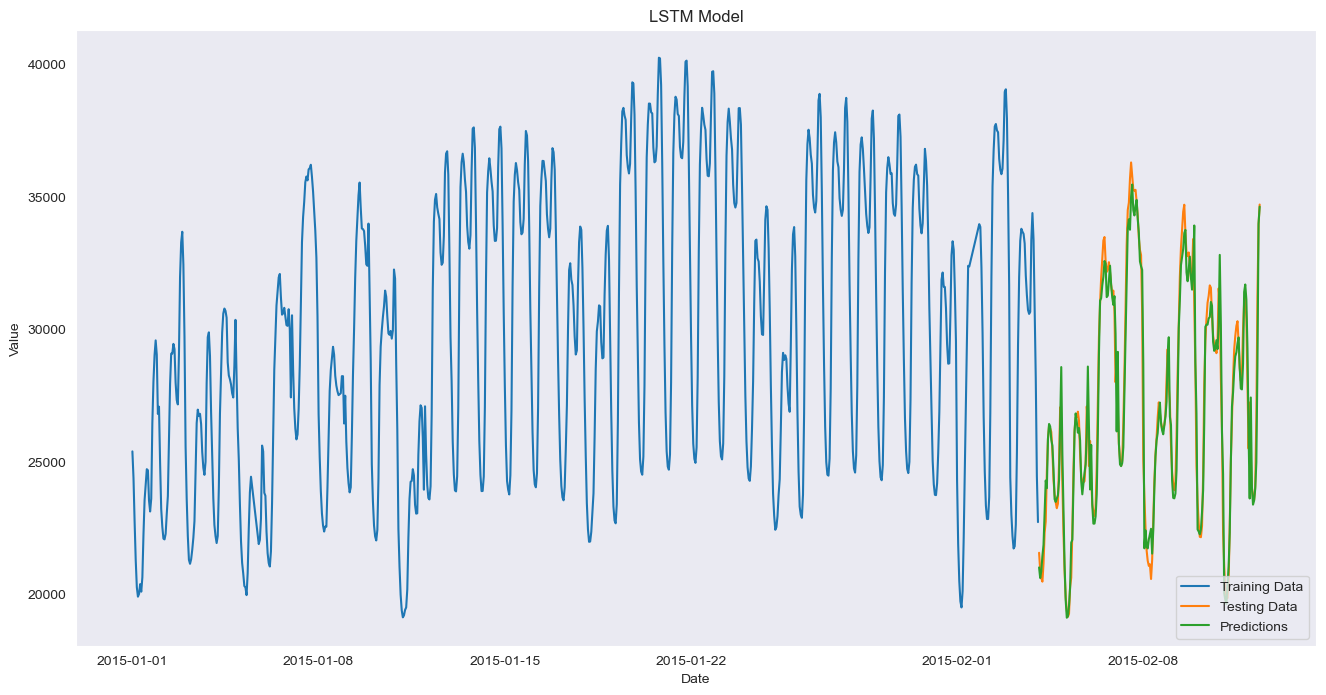

In [12]:
plt.figure(figsize=(16, 8))
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Value')
plt.plot(train['total load actual'])
plt.plot(valid[['total load actual', 'Predictions']])
plt.legend(['Training Data', 'Testing Data', 'Predictions'], loc='lower right')
plt.show()